In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          Dropout,
                          Bidirectional,
                          GlobalMaxPool1D,
                          Conv1D,
                          MaxPooling1D)

In [2]:

# Set seaborn style for better visualizations
sns.set(style="whitegrid")

# Set color palette for visualizations
colors = ["#4A6FE3", "#D33F49", "#74C365", "#E6B333"]

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# Load the fake news dataset
print("Loading and preparing the dataset...")
df = pd.read_csv("fake_or_real_news.csv", encoding="utf-8")


Loading and preparing the dataset...


In [4]:
# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nColumn information:")
print(df.info())


Dataset shape: (6335, 4)

First few rows:
      id                                              title  \
0   8476                       You Can Smell Hillary’s Fear   
1  10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2   3608        Kerry to go to Paris in gesture of sympathy   
3  10142  Bernie supporters on Twitter erupt in anger ag...   
4    875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6

In [5]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
id       0
title    0
text     0
label    0
dtype: int64


In [6]:

# Check class distribution
print("\nClass distribution:")
print(df['label'].value_counts())


Class distribution:
label
REAL    3171
FAKE    3164
Name: count, dtype: int64


In [8]:
# Add a column for text length
nltk.download('punkt_tab')
df['text_len'] = df['text'].apply(lambda x: len(word_tokenize(str(x))))
print("\nText length statistics:")
print(df['text_len'].describe())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Text length statistics:
count     6335.000000
mean       901.254301
std        991.387603
min          0.000000
25%        337.000000
50%        694.000000
75%       1185.500000
max      23966.000000
Name: text_len, dtype: float64


In [9]:

# Text preprocessing functions
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove links, remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


In [10]:
# Download stopwords
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c', 'said', 'also', 'say', 'says', 'said', 'mr', 'mrs']
stop_words = stop_words + more_stopwords


In [11]:

def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Initialize stemmer
stemmer = nltk.SnowballStemmer("english")

In [12]:

def stemm_text(text):
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

# Combined preprocessing function
def preprocess_text(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = stemm_text(text)
    return text


In [13]:

# Apply preprocessing
print("Preprocessing the text data...")
df['clean_text'] = df['text'].apply(preprocess_text)

# Encode labels
df['label_encoded'] = df['label'].map({'FAKE': 1, 'REAL': 0})


Preprocessing the text data...


In [14]:

# Create training and testing sets
X = df['clean_text']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")


Training set: 5068 samples
Testing set: 1267 samples


In [15]:
# Tokenization and padding
max_words = 20000
max_len = 300  # Adjusting for news articles which are typically longer than SMS

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 84125


In [16]:

# Convert text to sequences and pad
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [17]:

# Load GloVe embeddings
print("Loading GloVe embeddings...")
embedding_dim = 100
embeddings_index = {}

try:
    with open("glove.6B.100d.txt", encoding="utf8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    print(f"Found {len(embeddings_index)} word vectors in GloVe.")
except FileNotFoundError:
    print("GloVe file not found. Using random embeddings instead.")


Loading GloVe embeddings...
Found 400000 word vectors in GloVe.


In [18]:

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:


# Define model architecture - Enhanced version of the original LSTM model
def build_model():
    model = Sequential()

    # Embedding layer with GloVe weights
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ))

    # Convolutional layer to capture n-gram features
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))

    # Global max pooling to reduce dimensionality
    model.add(GlobalMaxPool1D())

    # Fully connected layers with dropout
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [20]:


# Create and train model
print("Building and training the model...")
model = build_model()
model.summary()

# Callbacks for model training
checkpoint = ModelCheckpoint(
    'fake_news_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


Building and training the model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     8,412,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,500 (32.09 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,412,500 (32.09 MB)

In [21]:

# Train the model
history = model.fit(
    X_train_pad,
    y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)


Epoch 1/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.5950 - loss: 0.7386
Epoch 1: val_loss improved from inf to 0.59617, saving model to fake_news_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 50s 531ms/step - accuracy: 0.5958 - loss: 0.7374 - val_accuracy: 0.7613 - val_loss: 0.5962 - learning_rate: 0.0010
Epoch 2/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7652 - loss: 0.4836
Epoch 2: val_loss improved from 0.59617 to 0.52201, saving model to fake_news_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 490ms/step - accuracy: 0.7654 - loss: 0.4834 - val_accuracy: 0.8028 - val_loss: 0.5220 - learning_rate: 0.0010
Epoch 3/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.8275 - loss: 0.3887
Epoch 3: val_loss improved from 0.52201 to 0.44352, saving model to fake_news_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 507ms/step - accuracy: 0.8275 - loss: 0.3887 - val_accuracy: 0.8225 - val_loss: 0.4435 - learning_rate: 0.0010
Epoch 4/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.8600 - loss: 0.3275
Epoch 4: val_loss improved from 0.44352 to 0.35849, saving model to fake_news_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 541ms/step - accuracy: 0.8601 - loss: 0.3274 - val_accuracy: 0.8462 - val_loss: 0.3585 - learning_rate: 0.0010
Epoch 5/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9011 - loss: 0.2374
Epoch 5: val_loss improved from 0.35849 to 0.31241, saving model to fake_news_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 509ms/step - accuracy: 0.9011 - loss: 0.2374 - val_accuracy: 0.8698 - val_loss: 0.3124 - learning_rate: 0.0010
Epoch 6/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.9331 - loss: 0.1644
Epoch 6: val_loss improved from 0.31241 to 0.29575, saving model to fake_news_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 582ms/step - accuracy: 0.9332 - loss: 0.1644 - val_accuracy: 0.8718 - val_loss: 0.2957 - learning_rate: 0.0010
Epoch 7/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9622 - loss: 0.1187
Epoch 7: val_loss did not improve from 0.29575
72/72 ━━━━━━━━━━━━━━━━━━━━ 75s 489ms/step - accuracy: 0.9622 - loss: 0.1187 - val_accuracy: 0.8481 - val_loss: 0.4643 - learning_rate: 0.0010
Epoch 8/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9665 - loss: 0.0872
Epoch 8: val_loss did not improve from 0.29575
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 504ms/step - accuracy: 0.9665 - loss: 0.0872 - val_accuracy: 0.8639 - val_loss: 0.4378 - learning_rate: 0.0010
Epoch 9/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9855 - loss: 0.0533
Epoch 9: val_loss did not improve from 0.29575

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 509ms/step - accuracy: 0.9855 - loss: 0.0534 - val_accuracy: 0.840

In [22]:

# Evaluate the model
print("Evaluating the model...")
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Evaluating the model...
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.8793 - loss: 0.3154
Test Loss: 0.3258
Test Accuracy: 0.8824


In [23]:
# Generate predictions
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step


In [24]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       634
           1       0.86      0.91      0.89       633

    accuracy                           0.88      1267
   macro avg       0.88      0.88      0.88      1267
weighted avg       0.88      0.88      0.88      1267



In [25]:
# Create visually appealing plots of training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], color=colors[0], linewidth=2, label='Training')
    ax1.plot(history.history['val_accuracy'], color=colors[1], linewidth=2, linestyle='--', label='Validation')
    ax1.set_title('Model Accuracy', fontsize=18, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(fontsize=12)
    ax1.tick_params(labelsize=12)

    # Plot training & validation loss
    ax2.plot(history.history['loss'], color=colors[0], linewidth=2, label='Training')
    ax2.plot(history.history['val_loss'], color=colors[1], linewidth=2, linestyle='--', label='Validation')
    ax2.set_title('Model Loss', fontsize=18, fontweight='bold')
    ax2.set_ylabel('Loss', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(fontsize=12)
    ax2.tick_params(labelsize=12)

    # Add a descriptive title to the entire figure
    plt.suptitle('Fake News Detection Model Training History', fontsize=22, y=1.05)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

In [26]:
# Plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['REAL', 'FAKE'],
        yticklabels=['REAL', 'FAKE'],
        linewidths=.5,
        cbar=False
    )
    plt.title('Confusion Matrix', fontsize=18, fontweight='bold')
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

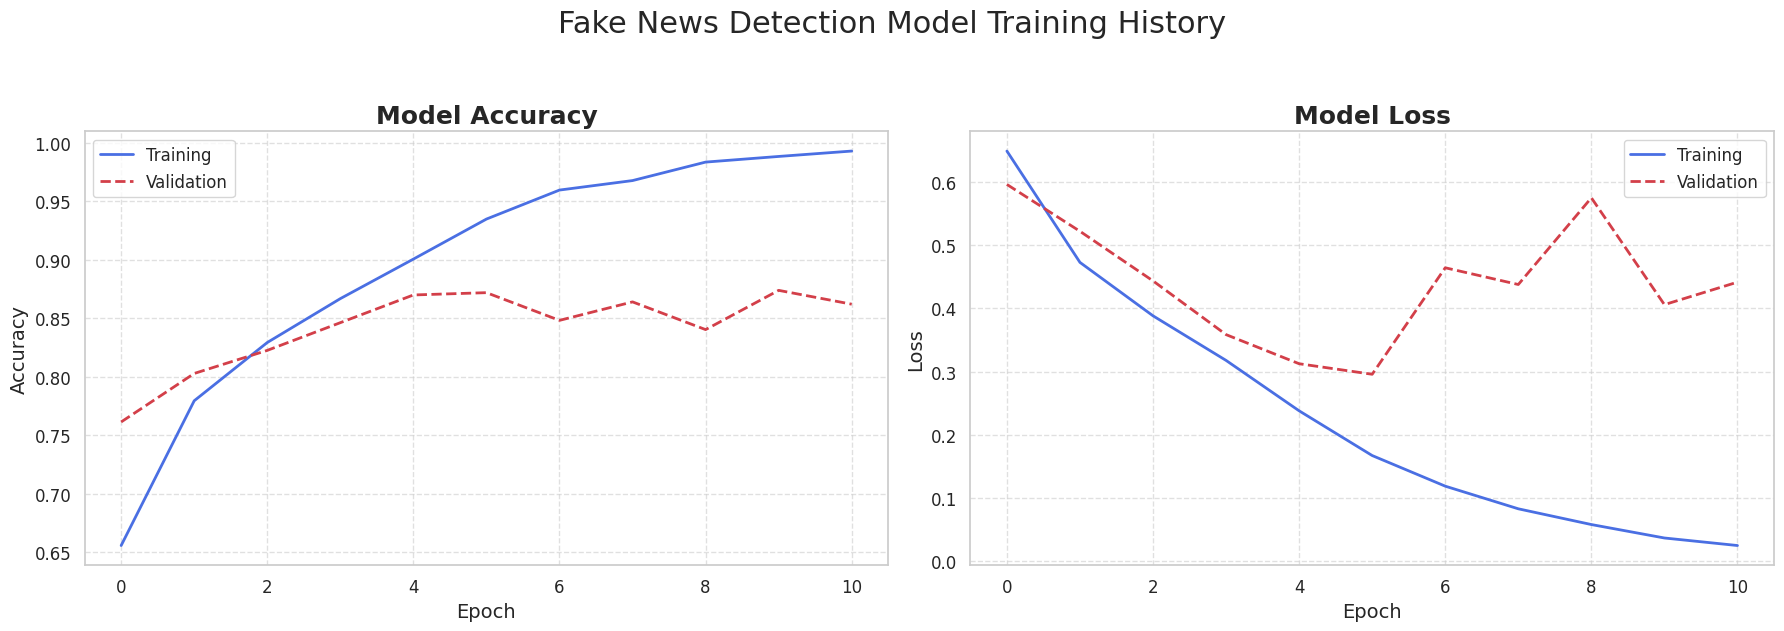

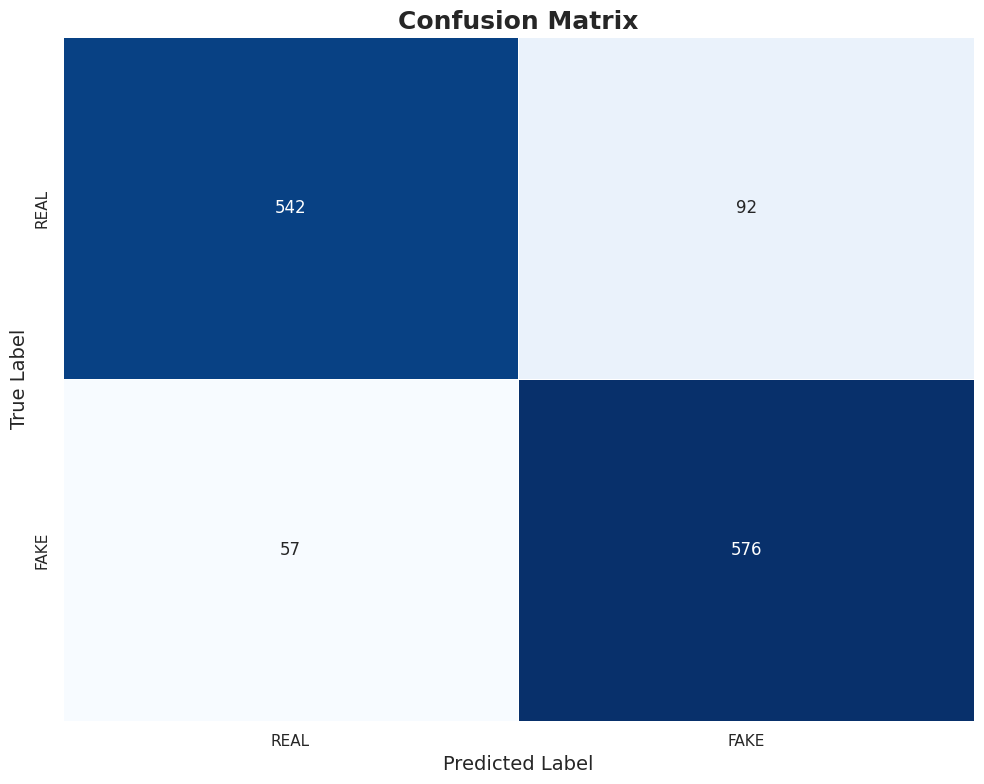

Model training and evaluation complete!


In [27]:
# Plot the results
plot_training_history(history)
plot_confusion_matrix(y_test, y_pred)

print("Model training and evaluation complete!")